In [10]:
!git clone https://github.com/yeaung276/FaceRecognization.git

Cloning into 'FaceRecognization'...
remote: Enumerating objects: 6687, done.
remote: Counting objects: 100% (473/473), done.
remote: Compressing objects: 100% (247/247), done.
^C


In [ ]:
!pip install tfx --quiet

In [1]:
!mkdir images && cd images

In [1]:
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip

--2023-11-09 16:11:07--  https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)|20.38.109.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2938553163 (2.7G) [application/octet-stream]
Saving to: ‘subjects_0-1999_72_imgs.zip’

subjects_0-1999_72_ 100%[===================>]   2.74G  8.33MB/s    in 5m 27s  

2023-11-09 16:16:35 (8.56 MB/s) - ‘subjects_0-1999_72_imgs.zip’ saved [2938553163/2938553163]



In [ ]:
!unzip subjects_0-1999_72_imgs.zip -d /content/images
!rm /content/subjects_0-1999_72_imgs.zip

In [2]:
%cd /content/FaceRecognization

/content/FaceRecognization


In [5]:
!pwd

/content/FaceRecognization


In [3]:
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.orchestration import metadata
from pipeline.example_gen import TripletExampleGen
from tfx.proto import example_gen_pb2

In [4]:
context = InteractiveContext(
    pipeline_root='/content/root',
    metadata_connection_config=metadata.sqlite_metadata_connection_config('/content/metadata')
    )

In [5]:
example_gen = TripletExampleGen(
    input_base='/content/images',
    sample_per_class=5,
    eval_split_ratio=0.2
    )
context.run(example_gen)

ExecutionResult(
    component_id: TripletExampleGen
    execution_id: 8
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=TripletExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [7]:
from tfx.dsl.components.common.importer import Importer
from tfx.types import standard_artifacts

model = Importer(
    source_uri='models/base-models/mobile-net',
    artifact_type=standard_artifacts.Model
  ).with_id('model_importer')

context.run(model)

ExecutionResult(
    component_id: model_importer
    execution_id: 9
    outputs:
        result: Channel(
            type_name: Model
            artifacts: [Artifact(artifact: id: 3
        type_id: 16
        uri: "models/base-models/mobile-net"
        custom_properties {
          key: "is_external"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.14.0"
          }
        }
        type: "Model"
        create_time_since_epoch: 1699546848681
        last_update_time_since_epoch: 1699546853574
        , artifact_type: id: 16
        name: "Model"
        base_type: MODEL
        )]
            additional_properties: {}
            additional_custom_properties: {}
            _input_trigger: None
        ))

In [8]:
from pipeline.embedding_gen import EmbeddingGen

encoding_gen = EmbeddingGen(
      examples=example_gen.outputs['examples'],
      model=model.outputs['result'],
      batch_size=600
    )
context.run(encoding_gen)

ExecutionResult(
    component_id: EmbeddingGen
    execution_id: 10
    outputs:
        output: OutputChannel(artifact_type=Examples, producer_component_id=EmbeddingGen, output_key=output, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [10]:
from tfx.dsl.components.common.importer import Importer
from tfx.types import standard_artifacts


hyperparameter = Importer(
  source_uri='pipeline/trainer/hyperparameters',
  artifact_type=standard_artifacts.HyperParameters
)

context.run(hyperparameter)

ExecutionResult(
    component_id: Importer
    execution_id: 11
    outputs:
        result: Channel(
            type_name: HyperParameters
            artifacts: [Artifact(artifact: id: 9
        type_id: 18
        uri: "pipeline/trainer/hyperparameters"
        custom_properties {
          key: "is_external"
          value {
            int_value: 1
          }
        }
        custom_properties {
          key: "tfx_version"
          value {
            string_value: "1.14.0"
          }
        }
        , artifact_type: id: 18
        name: "HyperParameters"
        )]
            additional_properties: {}
            additional_custom_properties: {}
            _input_trigger: None
        ))

In [11]:
from tfx.components import Trainer
from tfx.proto import trainer_pb2

trainer = Trainer(
      module_file='./pipeline/trainer/module_file.py',
      examples=encoding_gen.outputs['output'],
      hyperparameters=hyperparameter.outputs['result'],
      train_args=trainer_pb2.TrainArgs(num_steps=100),
      eval_args=trainer_pb2.EvalArgs(num_steps=5))
context.run(trainer)

Instructions for updating:
Use `tf.data.Dataset.map(tf.io.parse_example(...))` instead.


ExecutionResult(
    component_id: Trainer
    execution_id: 12
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

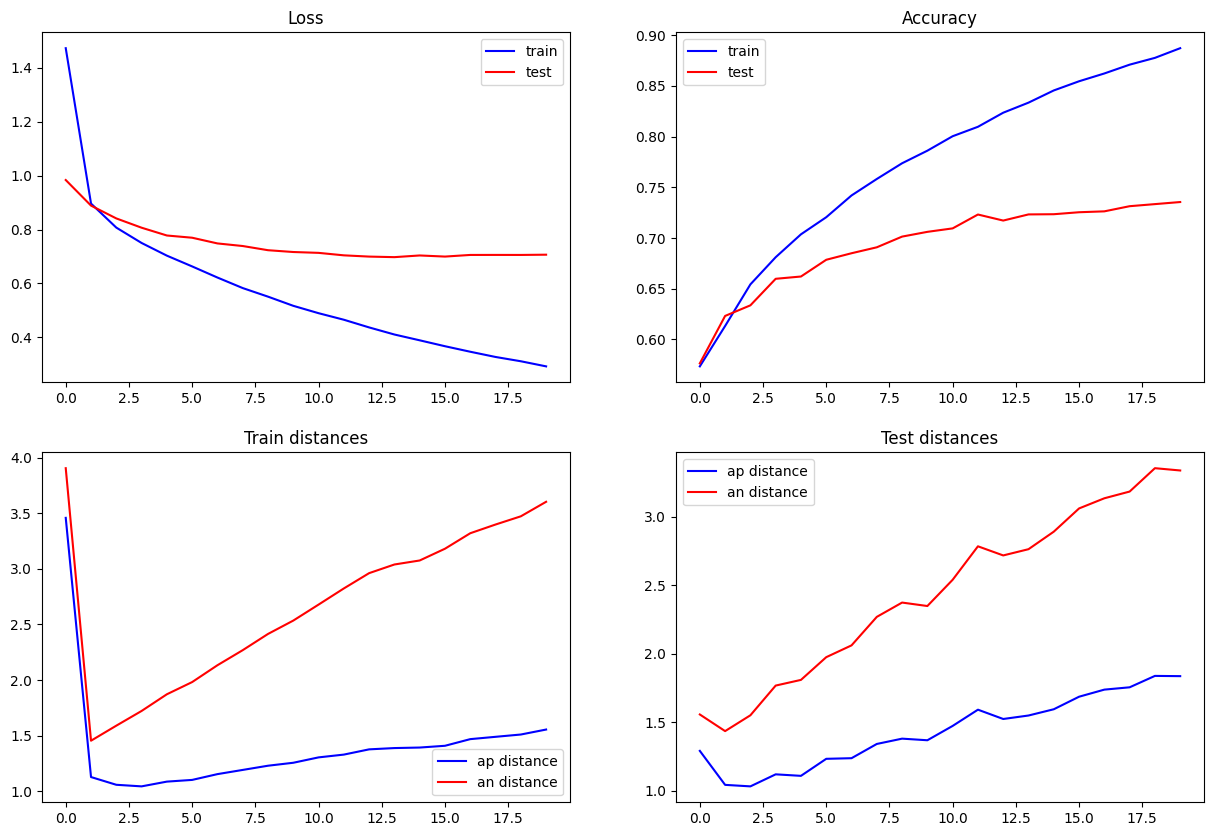

In [15]:
import matplotlib.pyplot as plt
import pickle
import os

file = open(os.path.join(trainer.outputs['model_run'].get()[0].uri, 'metrics.pkl'),'rb')
metrics = pickle.load(file)

plt.figure(figsize=(15,10))

# Plotting the loss over epochs
plt.subplot(221)
plt.plot(list(map(lambda x: x['train_loss'], metrics)), 'b', label='train')
plt.plot(list(map(lambda x: x['test_loss'], metrics)), 'r', label='test')
plt.title('Loss')
plt.legend()

# Plotting the accuracy over epochs
plt.subplot(222)
plt.plot(list(map(lambda x: x['train_acc'], metrics)), 'b', label='train')
plt.plot(list(map(lambda x: x['test_acc'], metrics)), 'r', label='test')
plt.title('Accuracy')
plt.legend()

# Plotting the distances over epochs
plt.subplot(223)
plt.plot(list(map(lambda x: x['train_ap'], metrics)), 'b', label='ap distance')
plt.plot(list(map(lambda x: x['train_an'], metrics)), 'r', label='an distance')
plt.title('Train distances')
plt.legend()

# Plotting the distances over epochs
plt.subplot(224)
plt.plot(list(map(lambda x: x['test_ap'], metrics)), 'b', label='ap distance')
plt.plot(list(map(lambda x: x['test_an'], metrics)), 'r', label='an distance')
plt.title('Test distances')
plt.legend()

plt.show()